# Planning course notebook

Planning is the art of producing a sequence of actions that brings an agent from given initial and goal states, knowing the model of the agent's state transition model.
While the dynamics of the environment can be deterministic or probabilistic, the main differences with Reinforcement Learning are the following:
- knowledge of a white-box state transition model defined as a state-to-state mapping or as a probability distribution over next states given the current state ;
- knowledge of the reward or cost function, or more specifically of a set of goal states to reach ;
- optimization of the sequence of actions, named a _plan_, offline without interacting with the environment but reasoning about the white-box state transition function.

It is worth mentioning that the reward or cost function can result from a simulation (e.g. aircraft performance model to compute fuel computation in flight planning).
Only the next state - or the probability distribution over next states - must be known beforehand by most planning algorithms.

## Definition of a planning problem

In its simplest form, a (deterministic) planning process is defined by a tuple $(S, A, T, C, s_i, G)$ where:
- $S$ is a finite set of states ;
- $A$ is a finite set of actions ;
- $T : S, A \rightarrow S$ is a transition function that maps a given state-action pair to a next state ;
- $C : S, A \rightarrow \mathbb{R}$ is a cost function that assigns a cost to a given state-action pair (transition) ;
- $s_i \in S$ is an initial state.
- $G \subset S$ is a set of goal states.

A _plan_ $\pi$ is a sequence of actions: $\pi \in \bigcup_{n \in \mathbb{N}_+} A^n$.
The execution of any given plan $\pi$ from the initial state $s_i$ produces a sequence of states $\sigma(\pi) = T( \cdots T( T(s_i, \pi[0]), \pi[1]), \cdots , \pi[n-1]) \in \bigcup_{n \in \mathbb{N}_+} S^n$ where $\vert \pi \vert$ is the length of $\pi$.
The cost of a plan $\pi$ is defined by $C(\pi) = \sum_{0 \leqslant n \leqslant \vert \pi \vert} c(\sigma(\pi)[n], \pi[n])$, i.e. the cumulative cost obtained by executing $\pi$ from the initial state $s_i$.

A planning problem $(\mathcal{P})$ consists in finding a plan that reaches a goal state in $G$ from the initial state $s_i$ in minimum cost:

$ \displaystyle (\mathcal{P}) \; \min_{\pi \in \bigcup_{n \in \mathbb{N}_+} A^n} C(\pi) \; \text{such that} \; \sigma(\pi)[n-1] \in G$

## A simple example: the famous maze problem

Let's consider a maze as defined with the following code below.

/var/folders/hp/p5lfqcrx34gcc58lq7_1kvnm0000gn/T/ipykernel_53344/724660161.py:105: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("Maze")


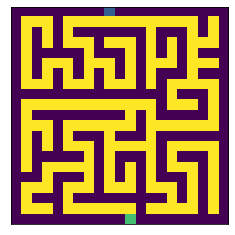

In [4]:
from copy import deepcopy
from enum import Enum
from typing import Any, NamedTuple, Tuple

%matplotlib inline
import matplotlib.pyplot as plt


DEFAULT_MAZE = """
+-+-+-+-+o+-+-+-+-+-+
|   |             | |
+ + + +-+-+-+ +-+ + +
| | |   |   | | |   |
+ +-+-+ +-+ + + + +-+
| |   |   | |   |   |
+ + + + + + + +-+ +-+
|   |   |   | |     |
+-+-+-+-+-+-+-+ +-+ +
|             |   | |
+ +-+-+-+-+ + +-+-+ +
|   |       |       |
+ + + +-+ +-+ +-+-+-+
| | |   |     |     |
+ +-+-+ + +-+ + +-+ +
| |     | | | |   | |
+-+ +-+ + + + +-+ + +
|   |   |   |   | | |
+ +-+ +-+-+-+-+ + + +
|   |       |     | |
+-+-+-+-+-+x+-+-+-+-+
"""


class State(NamedTuple):
    x: int
    y: int


class Action(Enum):
    up = 0
    down = 1
    left = 2
    right = 3


class Maze:
    def __init__(self, maze_str: str = DEFAULT_MAZE):
        maze = []
        for y, line in enumerate(maze_str.strip().split("\n")):
            line = line.rstrip()
            row = []
            for x, c in enumerate(line):
                if c in {" ", "o", "x"}:
                    row.append(1)  # spaces are 1s
                    if c == "o":
                        self._start = State(x, y)
                    if c == "x":
                        self._goal = State(x, y)
                else:
                    row.append(0)  # walls are 0s
            maze.append(row)
        # self._render_maze = deepcopy(self._maze)
        self._maze = maze
        self._num_cols = len(maze[0])
        self._num_rows = len(maze)
        self._ax = None
        self._image = None

    def get_transition_state_and_cost(self, state: State, action: Action) -> Tuple[State, float]:

        if action == Action.left:
            next_state = State(state.x - 1, state.y)
        if action == Action.right:
            next_state = State(state.x + 1, state.y)
        if action == Action.up:
            next_state = State(state.x, state.y - 1)
        if action == Action.down:
            next_state = State(state.x, state.y + 1)

        # If candidate next state is valid
        if (
            0 <= next_state.x < self._num_cols
            and 0 <= next_state.y < self._num_rows
            and self._maze[next_state.y][next_state.x] == 1
        ):
            return (
                next_state,
                abs(next_state.x - state.x) + abs(next_state.y - state.y)  # every move costs 1
            )
        else:
            return (
                state,
                2  # big penalty when hitting a wall
            )
    
    def get_initial_state(self) -> State:
        return self._start
    
    def is_goal(self, state: State) -> bool:
        return state == self._goal

    def render(self, state: State) -> Any:
        if self._ax is None:
            fig, ax = plt.subplots(1)
            fig.canvas.set_window_title("Maze")
            ax.set_aspect("equal")  # set the x and y axes to the same scale
            plt.xticks([])  # remove the tick marks by setting to an empty list
            plt.yticks([])  # remove the tick marks by setting to an empty list
            ax.invert_yaxis()  # invert the y-axis so the first row of data is at the top
            self._ax = ax
            plt.ion()
        maze = deepcopy(self._maze)
        maze[self._goal.y][self._goal.x] = 0.7
        maze[state.y][state.x] = 0.3
        if self._image is None:
            self._image = self._ax.imshow(maze)
        else:
            self._image.set_data(maze)
        # self._ax.pcolormesh(maze)
        # plt.draw()
        plt.pause(0.001)
        
maze = Maze()
maze.render(maze.get_initial_state())

The objective is to bring the blue agent at the top of the maze to the green cell in minimum time (i.e. minimum number of moves).
Each move costs 1 but 2 if the agent hits a wall or an obstacle.

How would you proceed? In theory, the number of plans is infinite. But even you restrict yourselves to, let's say, plans of at most $N > 0$ steps,
then the number of options is bounded by $\sum_{1 \leqslant n \leqslant N} 4^n = \frac{4^{N+1} - 1}{3}$ since there are 4 possible moves at each step.
It is obviously too much for a brute-force search.

If you are not convinced, let's consider a very simple 10 by 10 maze without obstacles. We can say that 20 is a reasonable upper bound for the number of steps
to go from one corner to the opposite one along the diagonal of the maze (and actually 2 is the right number of steps in that case).
The number of plans to explore, if we would do it naively one by one, would be equal to $1.5 \times 10^{12}$.
If each evaluation takes $1 \; \text{millisecond}$, it will take $1.5 \times 10^9 \; \text{seconds} = 47.5 \; \text{years}$!

Obviously, it takes a fraction of seconds for a human to find the solution...
So what do we do differently? First, we quickly extract the structure of the problem from our visual inputs, then we use our intuition based on our experience
and millions of years of evolution to try to move as much as possible the agent towards the cell goal as if we threw away the obstacles along the path.
We then locally adapt this intuitive path in order to avoid the obstacles, and if we are trapped in a dead-end, we then mentally backtrack to the previous position
in the maze were we could have taken another intuitive option.

Well, there is actually an algorithm which follows the same reasoning: the famous [A* algorithm](https://en.wikipedia.org/wiki/A*_search_algorithm).
The algorithmic counterpart of the intuitive guidance is the _heuristic_ function $h : S \rightarrow R$ which provides a lower bound on the cumulated cost
that would be needed to reach a goal state by following an optimal plan.

For the maze problem, where all moves cost 1 or 2, the so-called _flying distance_ $h(s) = \min_{s_g \in G} \Vert \overrightarrow{s_g} - \overrightarrow{s} \Vert$
is less than the cost of any plan that goes from $s$ to any state in $G$ (here we abuse the notation of a state $s$ as a vector $\overrightarrow{s}$ defined by
the $x$ and $y$ coordinates of the state).
Another heuristic which is more informative because closer to the optimal cost is the so-called _Manhattan distance_defined as
$h(s) = \min_{s_g \in G} \vert \overrightarrow{s_g} \cdot \overrightarrow{x} - \overrightarrow{s} \cdot \overrightarrow{x} \vert +
                         \vert \overrightarrow{s_g} \cdot \overrightarrow{y} - \overrightarrow{s} \cdot \overrightarrow{y} \vert$

## A* search algorithm

A* is a graph search algorithm where the planning problem is seen as traversing a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics))
$\mathcal{G} = (S, A)$ from a root node to some goal nodes.
As a user of A* who wants to solve a planning problem, the first thing to do consists in mapping the problem to a graph.

As shown in the [pseudo-code of A*](https://en.wikipedia.org/wiki/A*_search_algorithm#Pseudocode), the algorithm iteratively extends the graph by assigning
to each new node a score $f(n) = g(n) + h(n)$, where $g(n)$ is the cost of the best current path from the root node to $n$ and $h(n)$ is the heuristic cost
of $n$ as defined in the previous section. The $f$-score $f(n)$ represents the best guess of a path leading from the root node to the goal node by going through $n$.

The logic of the algorithm is quite simple: it will maintain a list of all the nodes that are not yet expanded, i.e. for which next possibles nodes have not yet been explored,
and it iteratively picks the node in the list with the lowest $f$-score to be expanded. Indeed, the nodes with the lowest $f$-scores are more likely to be part
of the optimal path to the goal node in the graph. The list of non-expanded explored nodes is called the _open_ list.

The algorithm then analyses all the already explored successors of the picked node (if any) and sees if the current best path to them is worth being updated by
going instead through the picked node. For this, the algorithm records the best current ancestor of all explored nodes. Then, it _closes_ the picked node.

The algorithm finishes when a goal node has been reached _and_ closed, i.e. has been chosen as the best node to close from the open list.
A classical mistake consists in exiting the search whenever a goal node has been reached, which is unfortunately *not* sufficient to reach optimality.
The optimal path from the root node to the goal node is obtained by reversely following the best ancestor of all nodes from the goal node.

A* is proven to return an optimal plan if the heuristic function $h$ is both _admissible_,
i.e. $h(n) \leqslant \min_{\pi \in \bigcup_{n \in \mathbb{N}_+} A^n} C(\pi) \; \text{such that} \; \sigma(\pi)[n-1] \in G$,
and _monotone_ or _consistent_, i.e. $h(n) \leqslant c(n, n') + h(n')$ for any node $n$ and its successor nodes $n'$.

<span style="background:green">A* is just one of many graph search algorithms. It is especially worth mentioning that local search algorithms, even if not optimal,
can be useful to solve large problems. A large amount of research works focus on automatically generating informative heuristics for complex domains
with multidimensional and non-Euclidean state spaces. Those interested can look at this useful [wiki on task planning research](https://planning.wiki/)</span>